In [42]:
%pylab inline

pylab.rcParams['figure.figsize'] = (6, 6)

import math
import cmath          # math functions for complex numbers
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.stats
import pandas as pd

from astropy.io import fits
import os.path

import ipywidgets
from ipywidgets import interact

import sys
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/datapipe")
import datapipe.denoising.wavelets_mrfilter as mrfilter

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


**TODO**:
* outils:
    * appeler mr_filter / mr_transform, afficher l'entrée, la sortie et les plans (+ histogrammes)
    * la même chose que la GUI
* charge loss
* threshold
* spellcheck

## Introduction

###  Context

On travaille sur des images provenant de simulations montecarlo de telescopes gamma (~100 GeV to ~300 TeV)

Exemple:
<img src="./figs/image31.gif" width="50%"></img>

Processus:
1. nettoyer l'image (suppression du bruit electronique et du NSB)
2. déterminer l'axe de la gerbe gamma sur l'image
3. par stereoscopie determiner l'origine de la gerbe

|                                                  |                                                  |
| ------------------------------------------------ | ------------------------------------------------ |
| <img src="./figs/image30.png" width="90%"></img> | <img src="./figs/image32.png" width="90%"></img> |
| <img src="./figs/image33.png" width="90%"></img> | <img src="./figs/Arrayscheme2_x.png" width="90%"></img> |


### Image types

#### FlashCam telescopes: 1764 (hexagonal) pixels

<img src="./figs/geom_3_flashcam.png" width="40%">

#### ASTRI telescopes: 2368 (rectangular) pixels

<img src="./figs/geom_4_astri.png" width="40%">

#### and others...

...

### Images I use so far

- Cropped images from Astri telescopes => 40x40 pixels
- Set of ~15000 images

<img src="./figs/geom_4_astri_crop3.svg" width="60%">

### Cleaning algorithm reference

The "Tailcut clean" algorithm:
- Keep pixels above a given threshold (10 PE)
- Keep some neighbors of these selected pixels: those above a second (lower) threshold (5 PE)

Goal:
- use sparse2d tools to get a better image cleaning (electronic noise and NSB removal)...
- to improve event reconstruction..
- and thus improve observatory's sensibility

## Some stats

### Total number of photoelectrons (NPE) per image

In [ ]:
%run ./utils/plot_metadata_histogram.py --key=npe --logx --title="Number of photoelectrons (NPE) per image" ./xps/2017_02_04/score_gamma_all_null_ref.json

### Noise histogram (telescope 1 only)

In [ ]:
%run ./utils/plot_noise_histogram.py --notebook --logy --min-npe=50 --max-npe=1500 ./testset/gamma/tel1/

abs(noise) $\sim \text{Poisson}(\lambda \approx 2)$

### Noise histogram (telescope 2 only)

In [ ]:
%run ./utils/plot_noise_histogram.py --notebook --logy --min-npe=50 --max-npe=1500 ./testset/gamma/tel2/

## Questions

### Remove isolated pixels after cleaning: l'option "-k" ne semble pas avoir d'effet

<img src="./figs/kill_isolated_pixels/ev458109_tel1.png" width="75%">

<img src="./figs/kill_isolated_pixels/ev481109_tel1_log.png" width="75%">

### Charge loss

**TODO...**

### Threshold WT

* hard filter do 1, 0.6, ...
* on voudrait faire le contraire: mettre un seuil plus bas pour les petites échelles (filtrer moins) et plus haut pour les grandes échelles (filtrer plus) pour conserver plus de détails (nos objets ne font que quelques pixels)

### Hexagonal images and corners

**Objectif n°1**: gérer les images ayant des "trous" dans les coins

Idée:
- pouvoir activer prématurement le "mirroring" d'un tuple de pixels (i.e. ce qui se passe quand on atteind le bord de l'image dans smooth_bspline) en mettant des pixels à une valeur particulière (FLOAT_MIN, NaN, ...)

<img src="./figs/geom_4_astri.png" width="40%">

**Objectif n°2**: travailler sur des images faites d'une grille de pixels hexagonaux

<img src="./figs/geom_3_flashcam.png" width="40%">

Idée:
    - ajouter une itération dans smooth_bspline: applique la convolution suivant un 3e axe
    - suppose de changer la structure de donnée des images (workaround de travailler avec des cubes)
    - l'idée n'est pas de changer la structure de donnée des images à un niveau global (imutilement long et compliqué) mais plutôt très localement pour une configuration particulière de filtre

<img src="./figs/hexagonal_grid.png" width="25%">

In [ ]:
# %load /Users/jdecock/bin/isap/cxx/sparse2d/src/libsparse2d/IM_Smooth.cc

void smooth_bspline (const Iint & Im_in,
                     Iint &Im_out,
                     type_border Type,
                     int Step_trou)
{
    int Nl = Im_in.nl();
    int Nc = Im_in.nc();
    int i,j,Step;
    float Coeff_h0 = 3. / 8.;
    float Coeff_h1 = 1. / 4.;
    float Coeff_h2 = 1. / 16.;
    Ifloat Buff(Nl,Nc,"Buff smooth_bspline");

    Step = (int)(pow((double)2., (double) Step_trou) + 0.5);

    for (i = 0; i < Nl; i ++)
    for (j = 0; j < Nc; j ++)
       Buff(i,j) = Coeff_h0 * (float)  Im_in(i,j)
                 + Coeff_h1 * (float) (  Im_in (i, j-Step, Type) 
                                       + Im_in (i, j+Step, Type)) 
                 + Coeff_h2 * (float) (  Im_in (i, j-2*Step, Type) 
                                       + Im_in (i, j+2*Step, Type));

    for (i = 0; i < Nl; i ++)
    for (j = 0; j < Nc; j ++)
       Im_out(i,j) = (int)(Coeff_h0 * Buff(i,j) +
                 + Coeff_h1 * (float) (  Buff (i-Step, j, Type) 
                                       + Buff (i+Step, j, Type)) 
                 + Coeff_h2 * (float) (  Buff (i-2*Step, j, Type) 
                                       + Buff (i+2*Step, j, Type)) + 0.5);

}

### Wrapper

Pour faire du filtrage en temps réel, l'utilisation de fichiers pour échanger les données avec mr_filter/mr_transform/... pose problème (temps d'accès aux fichiers trop long).

Idéalement il nous faudrait des wrappers Python.

Sinon, une amélioration possible peu couteuse en temps de developpement serait d'échanger les données via stdin/stdout.

## Tool functions

In [60]:
# %load /Users/jdecock/git/pub/jdhp/snippets/python/astropy/fits/print_infos.py
def fits_info(file_path):
    hdu_list = fits.open(file_path)
    hdu_list.info()
    hdu_list.close()

### Créer un fichier fits

In [43]:
# %load /Users/jdecock/git/pub/jdhp/snippets/python/astropy/fits/create_a_2d_fits_image_v2.py
def data_to_fits(img, file_path):
    hdu = fits.PrimaryHDU(img)

    if os.path.isfile(file_path):
        os.remove(file_path)

    hdu.writeto(file_path)

### Lire un fichier fits

In [46]:
def fits_to_data(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    data = hdu_list[0].data
    hdu_list.close()                # Close the FITS file
    return data

### Charger un fichier fits mrfilter

In [58]:
def read_mr_file(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    data = hdu_list[0].data
    hdu_list.close()                # Close the FITS file
    return data

### Charger un fichier fits sap-cta datapipe benchmark

In [24]:
def read_cta_file(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    
    if (len(hdu_list) != 7) or (not hdu_list[0].is_image) or (not hdu_list[1].is_image) or (not hdu_list[2].is_image) or (not hdu_list[3].is_image) or (not hdu_list[4].is_image) or (not hdu_list[5].is_image) or (not hdu_list[6].is_image):
        hdu_list.close()
        raise Exception("Wrong file structure")

    hdu0, hdu1, hdu2, hdu3, hdu4, hdu5, hdu6 = hdu_list

    # IMAGES
    images_dict = {}
    
    images_dict["input_image"] = hdu0.data        # "hdu.data" is a Numpy Array
    images_dict["reference_image"] = hdu1.data    # "hdu.data" is a Numpy Array
    images_dict["adc_sum_image"] = hdu2.data      # "hdu.data" is a Numpy Array
    #images_dict["pedestal_image"] = hdu3.data     # "hdu.data" is a Numpy Array
    #images_dict["gains_image"] = hdu4.data        # "hdu.data" is a Numpy Array
    #images_dict["calibration_image"] = hdu5.data  # "hdu.data" is a Numpy Array
    #images_dict["pixels_position"] = hdu6.data    # "hdu.data" is a Numpy Array
    
    hdu_list.close()                # Close the FITS file
    
    return images_dict

In [48]:
def plot(data, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    im = ax.imshow(data, interpolation='nearest', origin='lower', cmap="gnuplot2")   # cmap=cm.inferno and cmap="inferno" are both valid
    ax.set_title(title)
    
    plt.colorbar(im) # draw the colorbar
    plt.show()

## Sandbox

### Plot a cta fits file

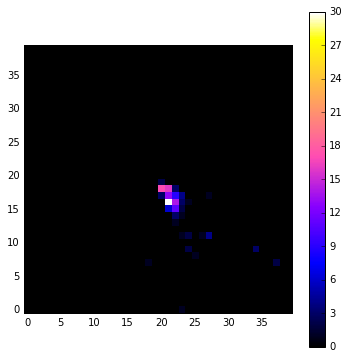

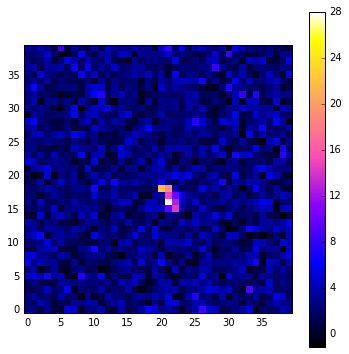

In [28]:
file_path = "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV00507.fits"

plot(read_cta_file(file_path)["reference_image"])
plot(read_cta_file(file_path)["input_image"])
#plot(read_cta_file(file_path)["adc_sum_image"][0])
#plot(read_cta_file(file_path)["calibration_image"][0])

### Run datapipe mrfilter cleaning

In [38]:
cleaning_algorithm = mrfilter.WaveletTransform()

In [39]:
data = read_cta_file(file_path)["input_image"]

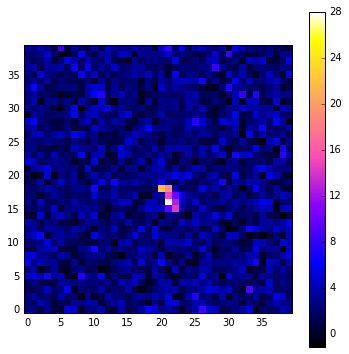

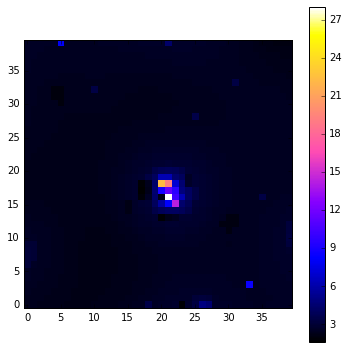

In [36]:
#cleaning_function_params = {
#                "type_of_multiresolution_transform": type_of_multiresolution_transform,
#                "type_of_filters": type_of_filters,
#                "type_of_non_orthog_filters": type_of_non_orthog_filters,
#                "number_of_scales": number_of_scales,
#                "suppress_last_scale": suppress_last_scale,
#                "suppress_isolated_pixels": suppress_isolated_pixels,
#                "kill_isolated_pixels": kill_isolated_pixels,
#                "coef_detection_method": coef_detection_method,
#                "k_sigma_noise_threshold": k_sigma_noise_threshold,
#                "noise_model": noise_model,
#                "detect_only_positive_structure": detect_only_positive_structure,
#                "suppress_positivity_constraint": suppress_positivity_constraint,
#                "type_of_filtering": type_of_filtering,
#                "first_detection_scale": first_detection_scale,
#                "number_of_iterations": number_of_iterations,
#                "epsilon": epsilon,
#                "support_file_name": support_file_name,
#                "precision": precision,
#                "offset_after_calibration": offset_after_calibration,
#                "correction_offset": correction_offset,
#                "input_image_scale": input_image_scale,
#                "verbose": verbose
#}

out = cleaning_algorithm.clean_image(data, raw_option_string="")

plot(data)
plot(out)

### Make a fits file for mr_filter

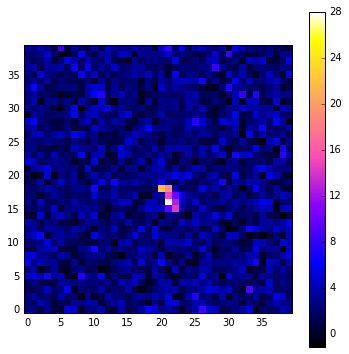

In [49]:
data = read_cta_file(file_path)["input_image"]

data_to_fits(data, "test.fits")
plot(fits_to_data("test.fits"))

### Call mr_filter

In [62]:
!mr_filter -h

Usage: mr_filter options in_image out_image

   where options =  
         [-f type_of_filtering]
              1: Multiresolution Hard K-Sigma Thresholding 
              2: Multiresolution Soft K-Sigma Thresholding 
              3: Iterative Multiresolution Thresholding 
              4: Adjoint operator applied to the multiresolution support  
              5: Bivariate Shrinkage 
              6: Multiresolution Wiener Filtering 
              7: Total Variation + Wavelet Constraint 
              8: Wavelet Constraint Iterative Methods 
              9: Median Absolute Deviation (MAD) Hard Thesholding 
              10: Median Absolute Deviation (MAD) Soft Thesholding 
              default is Multiresolution Hard K-Sigma Thresholding.

         [-C Coef_Detection_Method]
              1: K-SigmaNoise Threshold
              2: False Discovery Rate (FDR) Theshold
              3: Universal Threshold
              4: SURE Threshold
              5: Multiscale SURE Threshold
      

Filename: out.mr
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      10   (40, 40)     float32   


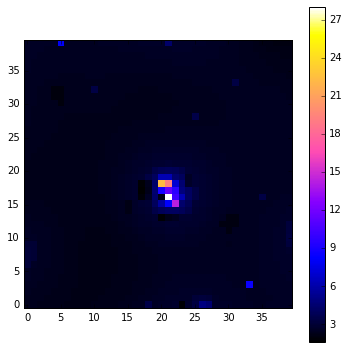

In [67]:
!mr_filter test.fits out.mr

fits_info("out.mr")
plot(read_mr_file("out.mr"))

### Call mr_filter and plot planes

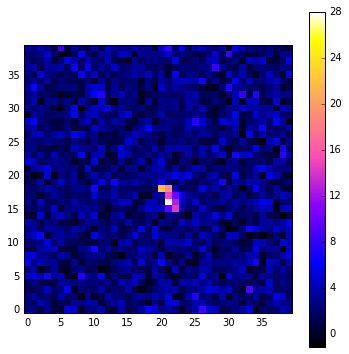

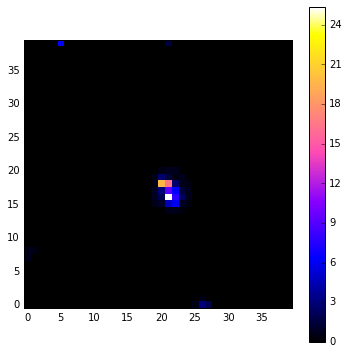

Filename: planes.mr
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      20   (40, 40, 4)   float32   


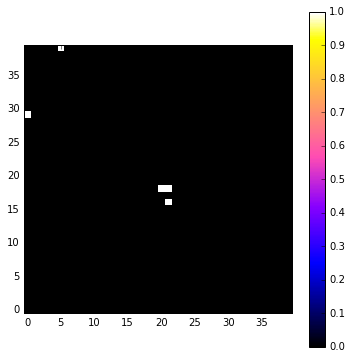

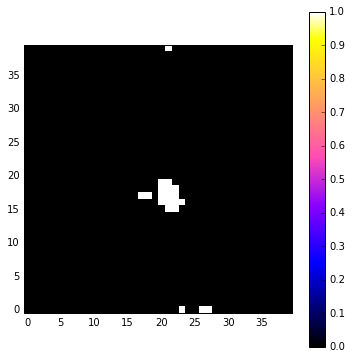

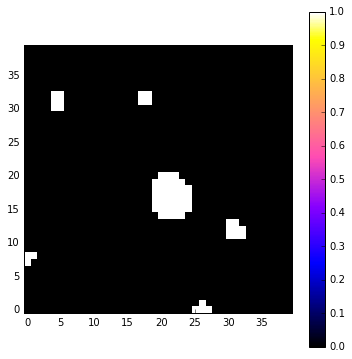

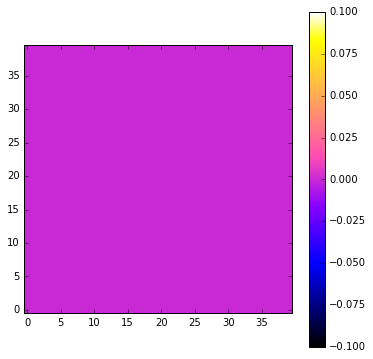

In [74]:
!mr_filter -w planes.mr -K -k -C1 -m3 -s3 -n4 test.fits out.mr

plot(read_mr_file("test.fits"))
plot(read_mr_file("out.mr"))

fits_info("planes.mr")

plot(read_mr_file("planes.mr")[0])
plot(read_mr_file("planes.mr")[1])
plot(read_mr_file("planes.mr")[2])
plot(read_mr_file("planes.mr")[3])